# Part 4, Topic 1: Power and Hamming Weight Relationship

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *In the previous part of SCA101, we used the fact a relationship exists between the value of the bits being manipulated on a microcontroller to recover an AES key*

*In this lab, we'll improve our model by looking at how power relates to hamming weight.*

**LEARNING OUTCOMES:**

* Understand hamming weight
* Calculate hamming weight of a byte
* Identify the point where the SBox output is being written
* Plot power consumption at the SBox output vs. hamming weight


## AES Model

We'll be looking at the SBox again, so grab your implementation from the last section:

In [38]:
from cwtraces import sca101_lab_data
import chipwhisperer as cw

data = sca101_lab_data["lab4_1"]()
trace_array =  data["trace_array"]
textin_array = data["textin_array"]
key = data["key"]

In [39]:
#raise NotImplementedError("Add your code here, and delete this.")
def aes_secret(inputdata):
    secret_key = 0xEF
    return aes_internal(secret_key, inputdata)
# ###################
# START SOLUTION
# ###################
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]
# ###################
# END SOLUTION
# ###################

In [40]:
#Simple test vectors - if you get the check-mark printed all OK.
assert(aes_internal(0xAB, 0xEF) == 0x1B)
assert(aes_internal(0x22, 0x01) == 0x26)
print("✔️ OK to continue!")

✔️ OK to continue!


In [41]:
print(len(textin_array))
print(len(textin_array[0]))

1000
16


In [42]:
print(len(trace_array))
print(len(trace_array[0]))

1000
5000


## Hamming Weight

Recall that the reason that there's a relationship between power consumption and the microcontroller's internal data is that setting this data takes power. We've also seen that the more data that is set, the greater the average power draw. It's not far fetched, then, that there should be some sort of consistant relationship between the number of bits set to 1, called the **Hamming weight** and the power consumed by doing so.

Hamming weight, despite being a pretty simple idea, actually isn't trivial to calculate (see https://en.wikipedia.org/wiki/Hamming_weight#Efficient_implementation). You can write a function to do this, but in Python it's far easier to just convert to a string of bits and count the `"1"`s:

In [6]:
def calc_hamming_weight(n):
    return bin(n).count("1")

Even better, create a lookup table (aka do the calculation for each number between 0 and 255 and stick them in an array):

In [7]:
HW = [calc_hamming_weight(i) for i in range(0x100)]

In [8]:
max_val = max(HW)

In [9]:
assert HW[0x53] == 4
print("✔️ OK to continue!")

✔️ OK to continue!


Our first issue that we run into is that we don't know where the SBox operation is happening. It should be happening pretty close to the beginning (let's guess and say within the first 2000 samples). One thought is that we could group the traces by hamming weight and assign a colour to each one. If we plot that, we might be able to find a pattern:

In [228]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

plot_start = 0
plot_end = 2000
bnum = 0
data = [[] for _ in range(9)] 

for tnum in range(len(trace_array)):
    hw_category = HW[aes_internal(textin_array[tnum][bnum], key[bnum])]
    data[hw_category].append(np.array(trace_array[tnum][plot_start:plot_end]))
    
hw_frame_data = {}

for index in range(len(data)):
    hw_frame_data[str(index)] = np.average(data[index], axis=0)

hw_frame_data['x'] = np.array(list(range(plot_end - plot_start)))
hw_frame = pd.DataFrame(hw_frame_data)
#hw_frame['hw_byte'] = [HW[aes_internal(textin_array[tnum][bnum], key[bnum])] for tnum in range(len(trace_array))]
#hw_frame['line_id'] = [tnum for tnum in range(len(trace_array))]
    
#long_hw_frame = hw_frame.melt(id_vars=['line_id', 'hw_byte'], var_name='x', value_name='y')

rgb = px.colors.convert_colors_to_same_type(px.colors.sequential.Inferno)[0]

colorscale = []
n_steps = 1  # Control the number of colors in the final colorscale
for i in range(len(rgb) - 2, -1, -1):
    for step in np.linspace(0, 1, n_steps):
        colorscale.append(px.colors.find_intermediate_color(rgb[i], rgb[i + 1], step, colortype='rgb'))

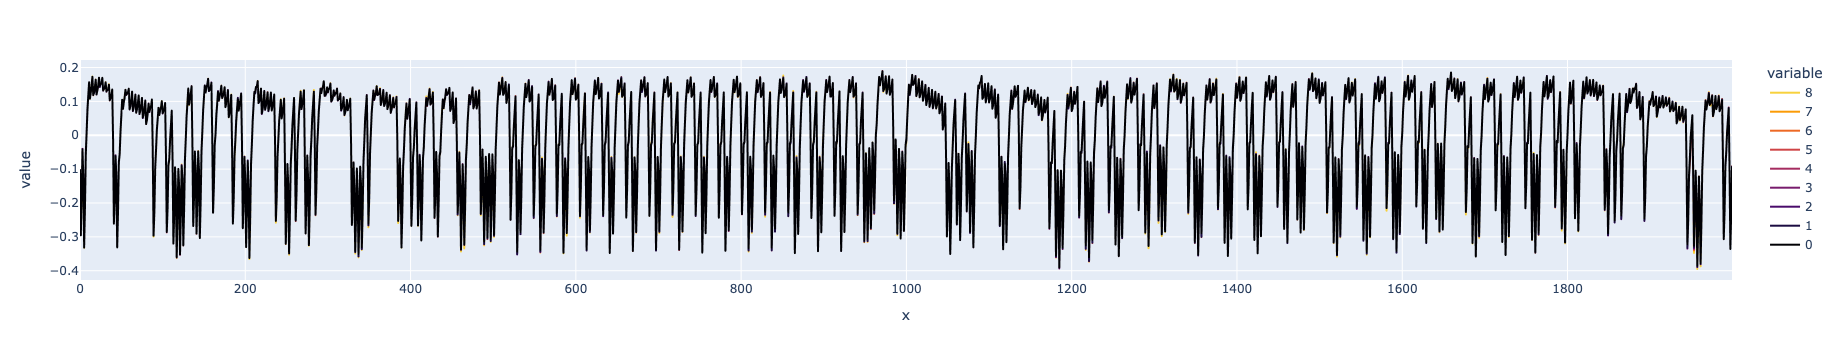

In [229]:
px.line(hw_frame,
        x='x',
        y=[str(i) for i in range(8,-1,-1)],
        color_discrete_sequence=colorscale).show()

Unfortunately, you'll probably find that this plot doesn't really tell us much; the part of power consumption associated with the SBox output is just too small to pick out. We could try averaging the hamming weight groups to make things more distinct, but that doesn't solve the fundamental issue of the SBox output being lost in the noise of everything else happening on the chip.

Instead, let's approach this from a different angle. Really, what we want here is to remove the overall "shape" of the trace and just leave the signal from the SBox output. We could just pick a trace and subtract it from each group, but subtracting an average of all the traces instead will make the plot more distinct. Even better would be to have an even weighting between all of the hamming weight groups, since the extreme hamming weights (0 and 8) are far less common than the middle values, but this won't end up being super necessary (though you can still attempt this if you'd like).  The plot will also be more distinct (and plot a lot faster) if we average all the hamming weight groups to remove any outliers as well. Try implementing this (we'll again handle the plotting for you):

In [19]:
import numpy as np
import itertools as it

xrange = list(range(len(trace_array[0]))[plot_start:plot_end])
# Use groupby on the sorted data using the second element as key
hw_groups = [[item[0] for item in group]\
                 for key, group\
                 in it.groupby(sorted([(trace_array[tnum][plot_start:plot_end], HW[aes_internal(textin_array[tnum][0], key[0])])\
                               for tnum\
                               in range(len(trace_array))],\
                            key=lambda x: x[1]),\
                  key=lambda x: x[1])]

num_of_categories = len(hw_groups)
#cmap = plt.cm.managua
#colors = [cmap(i / (num_of_categories - 1)) for i in range(num_of_categories)]
hw_averages = np.array([np.average(hw_groups[hw], axis=0) for hw in range(9)])
avg_trace = np.average(hw_averages, axis=0)
#to_trace = [(hw_averages[value] - avg_trace, str(value), mcolors.to_hex(colors[value])) for value in range(len(hw_averages))]

hw_average_data = {}
for value in range(len(hw_averages)):
    hw_average_data[str(value)] = hw_averages[value] - avg_trace

hw_averages_frame = pd.DataFrame(hw_average_data, index=xrange)

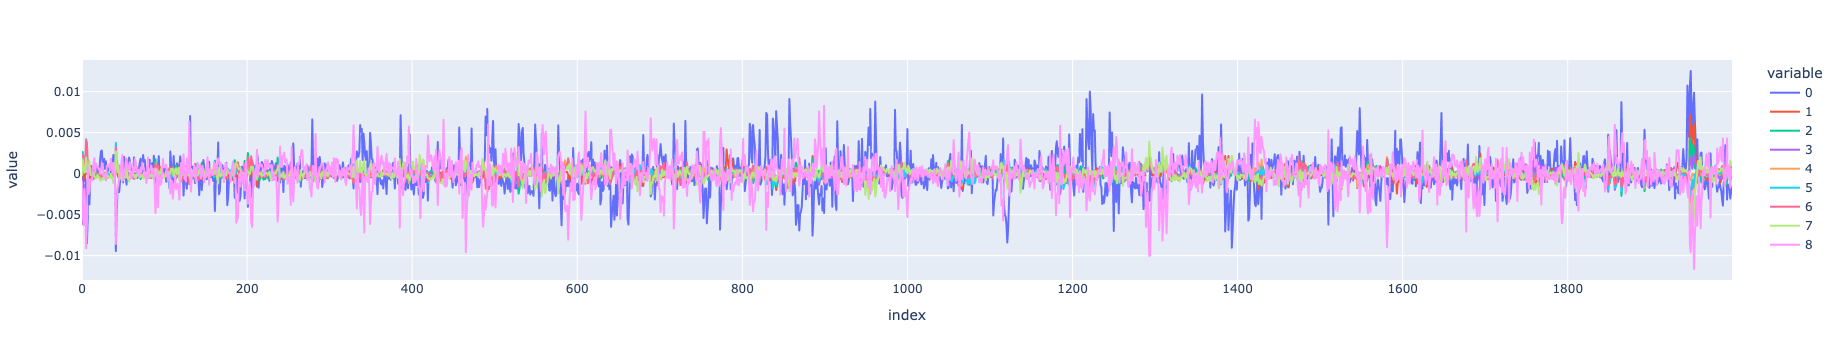

In [20]:
px.line(hw_averages_frame, markers=False).show()

Plotting this, you should get a very distinct spot where the colours separate. This is where the SBox operation is occuring. In fact, it's probably distinct enough that you can choose the SBox loction solely by where the graph is largest:

In [26]:
sbox_loc = np.argmax(abs(hw_averages[0]-avg_trace))

In [27]:
print(sbox_loc)

1949


Now that we know where the SBox operation is happening, plot the hamming weight averages by their hamming weight at `sboc_loc`.

**HINT: You may want to convert your hw_averages to a numpy array to allow you to access by column. `hw_averages[:,sbox_loc]` will give you `hw_averages` at the sbox_loc.**

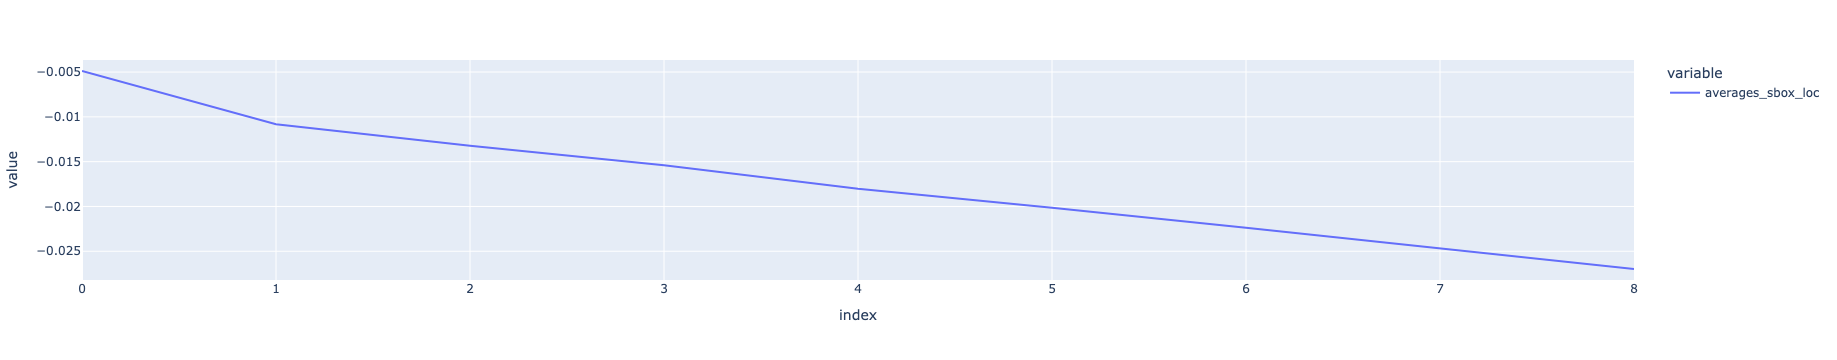

In [24]:
# ###################
# Add your code here
# ###################
data = {"averages_sbox_loc": hw_averages[:, sbox_loc]}
hw_averages_loc_frame = pd.DataFrame(data, index=list(range(len(hw_averages))))
px.line(hw_averages_loc_frame, markers=False).show()

You should find that the relationship is mostly linear, which probably won't come out of left field. It makes sense that setting 8 data bits will take roughly 8x the power that setting one does. 

You will likely also find that the slope of the relationship is negative, unless you're on the ChipWhisperer Nano. This happens for a good reason. If you remember how we are measuring the current into the device, you'll find out that the voltage will go DOWN for an INCREASE in current. You can see this in the following figure:

```     
        Rshunt
(Vin)----v^v^v^----------||------(To ChipWhisperer)
                |
                |
       (To microcontroller)
```

For the ChipWhisperer Nano, the slope is positive due to the presence of an inverting amplifier on the input of the measurement port.

We are measuring the drop across the shunt resistor. An increase in the current causes a higher voltage across the resistor. When no current flows there is no drop across the resistor. But since we only measure a single end of the resistor, we see a higher voltage when no current flows.

We can fix the slope by simply inverting the measurement direction (adding a - in front of the measurement).

Now that we know where the SBox operation is happening, try going back to the original plot and zoom in to that section. Can you pick out the difference between the hamming weights now?

## Conclusions & Next Steps

With this lab, you should be reasonably convinced that there is a linear relationship between the hamming weight of data being set in a microcontroller and the power it consumes from doing so.

In the next lab, we'll see how this can be used to greatly improve over our DPA attack.

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>